**<font color="blue">Roberta Model</font>**
<br/>WANDB Project Link : https://wandb.ai/meghacnair96-the-university-of-texas-at-dallas/emotion_detection/runs/kvbkgavr?nw=nwusermeghacnair96

In [ ]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/Applied NLP'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannorr/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 90.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.7/472.7 kB 38.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.9/330.9 kB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 91.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 19.5 MB/s eta 0:00:00


**<font color="blue">Step 1: Import the necessary libraries</font>**

In [ ]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path


# New libraries introduced in this notebook
import evaluate
from datasets import load_dataset, DatasetDict
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig
from transformers import pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login

**<font color="blue">Step 2: Login to Hugging Face and WAND</font>**

In [ ]:
wandb_api_key = userdata.get('WAND_API_KEY')
hf_token = userdata.get('HF_Token')

In [ ]:
if hf_token:
    # Log in to Hugging Face
    login(token=hf_token)
    print("Successfully logged in to Hugging Face!")
else:
    print("Hugging Face token not found in notebook secrets.")

The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Successfully logged in to Hugging Face!


In [ ]:
if wandb_api_key:
  wandb.login(key=wandb_api_key)
  print("Successfully logged in to WANDB!")
else:
    print("WANDB key not found in notebook secrets.")


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Successfully logged in to WANDB!


In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'data'
model_folder = base_folder/'models'
custom_functions = base_folder/'Codes/Custom py classes'

In [ ]:
base_folder


PosixPath('/content/drive/MyDrive/Applied NLP')

**<font color="blue">Step 3: Read data</font>**

In [ ]:
traindata = pd.read_csv(data_folder/'train.csv')
testdata = pd.read_csv(data_folder/'test.csv')

In [ ]:
traindata.head()


,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


**<font color="blue">Step 4: Since most encoder models can accept only a fixed sequence length it is important to check for the sequence length distribution</font>**

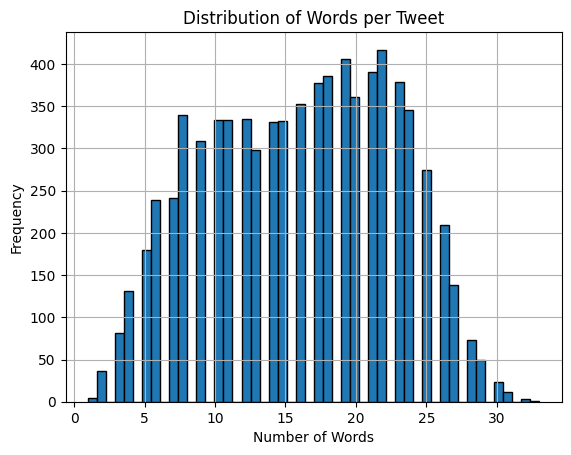

In [ ]:
import matplotlib.pyplot as plt

traindata['Tweet'] =traindata['Tweet'].fillna('')
# Calculate words per review
traindata['words_per_tweet'] = traindata["Tweet"].str.split().apply(len)
# Plot a histogram of the 'words_per_review' column
traindata['words_per_tweet'].hist(bins=50, edgecolor='black')

# Adding labels and a title for clarity
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Words per Tweet')

# Display the plot
plt.show()

**<font color="blue">Step 5: Split the data into training and validation sets</font>**

In [ ]:
from sklearn.model_selection import train_test_split

# Assuming your DataFrame is named df
X = traindata['Tweet']  # Features (the text data)
y = traindata[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']]  # Labels

# Splitting into 80% train and 20% validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine the split sets into DataFrames if needed
train_df = pd.DataFrame({'Tweet': X_train, **y_train})
val_df = pd.DataFrame({'Tweet': X_val, **y_val})

test_df = pd.DataFrame({'Tweet': testdata['Tweet']})



**<font color="blue">Step 6: Create HuggingFace datasets</font>**

In [ ]:
from datasets import Dataset, DatasetDict

# Convert train and validation DataFrames to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_df)
valid_dataset = Dataset.from_pandas(val_df)

# Now create the DatasetDict
train_val = DatasetDict(
    {"train": train_dataset, "valid": valid_dataset}
)


**<font color="blue">Step 7: Import tokensizer and tokenize the data</font>**

In [ ]:
from transformers import AutoTokenizer

checkpoint = "roberta-base"  # or "roberta-large" if you prefer a larger model
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def tokenize_fn(batch):
    # Tokenize the text
    tokenized_inputs = tokenizer(batch["Tweet"], truncation=True, padding=True)
    # Extract and format the labels as float32
    labels = [
        [float(batch[label][i]) for label in ["anger", "anticipation", "disgust", "fear", "joy",
                                              "love", "optimism", "pessimism", "sadness",
                                              "surprise", "trust"]]
        for i in range(len(batch["Tweet"]))
    ]
    # Add labels to the tokenized inputs
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


In [ ]:
tokenized_dataset = train_val.map(tokenize_fn, batched=True)

print(tokenized_dataset["train"][0]["labels"])  # Should print a list of 11 values
print(len(tokenized_dataset["train"]["labels"][0]))  # Should print 11


Map:   0%|          | 0/6179 [00:00<?, ? examples/s]

Map:   0%|          | 0/1545 [00:00<?, ? examples/s]

[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0]
11


**<font color="blue">Step 8: Check for class imbalance and then calculate the appropriate weights for each label</font>**

In [ ]:
# Calculate the frequency of each class (emotion)
class_counts = traindata[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].sum()

# Display the class counts to check for imbalance
print(class_counts)
#We can see that the class distributions are not balanced

anger           2859
anticipation    1102
disgust         2921
fear            1363
joy             2877
love             832
optimism        2291
pessimism        895
sadness         2273
surprise         396
trust            400
dtype: int64


In [ ]:
import torch
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)



In [ ]:
pos_weights = calculate_pos_weights(tokenized_dataset)

In [ ]:
pos_weights

tensor([ 1.7018,  6.0216,  1.6576,  4.8403,  1.6657,  8.0734,  2.3256,  7.7274,
         2.4082, 17.9540, 19.0617])

**<font color="blue">Step 9: Import Roberta-base Model</font>**

In [ ]:
from transformers import AutoModelForSequenceClassification

checkpoint = "roberta-base"  # or whichever RoBERTa checkpoint you're using
num_labels = 11  # Number of emotion labels

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=num_labels,problem_type="multi_label_classification")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [ ]:
from transformers import AutoConfig

# Initialize the configuration
config = AutoConfig.from_pretrained(checkpoint)

# Get label names directly from your dataset columns
class_names = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

# Create mappings for id2label and label2id
id2label = {id_: label for id_, label in enumerate(class_names)}
label2id = {label: id_ for id_, label in enumerate(class_names)}

# Assign mappings to config
config.id2label = id2label
config.label2id = label2id

# Update model configuration
model.config = config


In [ ]:
import numpy as np
import evaluate
import torch
f1_metric = evaluate.load("f1","multilabel")

def compute_metrics(eval_pred):
  # Load F1 metric designed for multilabel classification
    f1_metric = evaluate.load("f1","multilabel")

    # Unpack logits and labels
    logits, labels = eval_pred

    # Convert logits to probabilities using sigmoid (for multilabel classification)
    probabilities = torch.sigmoid(torch.tensor(logits))

    predictions = (probabilities > 0.5).int().numpy()

    # Compute F1 macro for multilabel classification
    f1 = f1_metric.compute(
        predictions=predictions,
        references=labels,
        average="macro"  # Macro averaging
    )

    return f1


In [ ]:
# Define the directory where model checkpoints will be saved
run_name = "EmotionDetection-Roberta"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # learning rate
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=100,  # Perform evaluation every 100 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=100,  # Save a model checkpoint every 100 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    fp16=True,


)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1559: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


**<font color="blue">Step 10: To account for pos_weights we redefine the compute_loss function of the trainer and create a Customtrainer</font>**

In [ ]:
import torch.nn as nn
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss

In [ ]:
# initialize trainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)


<ipython-input-53-74c1b3da660b>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


In [ ]:
%env WANDB_PROJECT = emotion_detection

env: WANDB_PROJECT=emotion_detection


In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,F1
100,0.729500,0.743630,0.547931
200,0.656500,0.746011,0.561763
300,0.639500,0.749564,0.558551
400,0.586800,0.739084,0.572752
500,0.527400,0.764932,0.567837
600,0.608200,0.741194,0.565590
700,0.573400,0.751726,0.574583


TrainOutput(global_step=774, training_loss=0.6160391134809154, metrics={'train_runtime': 256.5213, 'train_samples_per_second': 48.175, 'train_steps_per_second': 3.017, 'total_flos': 989876023083540.0, 'train_loss': 0.6160391134809154, 'epoch': 2.0})

**From the above training output we can see that the best F1-score is achieved at step 700, but looking at the training loss and validation loss it makes more sense to pick the model at step 400, as post that we can see increases in Training and validation loss increases post that. But since our aim is to get the best f1 and the evaluation is based on f1 lets pick the model at 700. Further changes to hyper parameters like learning rate and weight decay can be adjusted to get consistent and better results in future.**

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 700.


**<font color="blue">Step 11: Calculate the optimal thresholds for all the labels.</font>**

In [ ]:
from scipy.special import expit as sigmoid
valid_output = trainer.predict(tokenized_dataset["valid"])

# Get probabilities from logits
valid_logits = valid_output.predictions
valid_probs = sigmoid(valid_logits)
valid_labels = np.array(valid_output.label_ids.astype(int))

In [ ]:
def find_best_thresholds_multilabel(probabilities, labels):
    """
    Find best threshold for each label that maximizes F1 score

    Args:
        probabilities: Array of shape (n_samples, n_labels) with predicted probabilities
        labels: Array of shape (n_samples, n_labels) with true binary labels

    Returns:
        thresholds: List of best thresholds for each label
        metrics: Dictionary containing best F1, precision, and recall for each label
    """
    n_labels = labels.shape[1]
    best_thresholds = []
    metrics = {}

    for label_idx in range(n_labels):
        # Get scores and labels for this label
        label_scores = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # Sort by scores
        rows = list(zip(label_scores, label_true))
        rows = sorted(rows, key=lambda x: x[0], reverse=True)

        # Initialize metrics
        best_f1 = best_precision = best_recall = 0
        threshold = 0

        # Count total positives for this label
        total_positives = sum(label_true)

        # Initialize counters
        total_predicted_positives = 0
        true_positives = 0

        # print(f"\nAnalyzing label {label_idx}")

        # Try different thresholds
        for i in range(len(rows) - 1):
            score, label = rows[i]
            total_predicted_positives += 1
            if label == 1:
                true_positives += 1

            if true_positives > 0:
                precision = true_positives / total_predicted_positives
                recall = true_positives / total_positives
                f1 = 2 * precision * recall / (precision + recall)

                # Update best metrics if current F1 is better
                if f1 > best_f1:
                    best_f1 = f1
                    best_precision = precision
                    best_recall = recall
                    threshold = (rows[i][0] + rows[i + 1][0]) / 2

                    # print(f"New best threshold found: {threshold:.3f}")
                    # print(f"F1: {best_f1:.3f}, Precision: {best_precision:.3f}, Recall: {best_recall:.3f}")

        best_thresholds.append(threshold)
        metrics[label_idx] = {
            'f1': best_f1,
            'precision': best_precision,
            'recall': best_recall,
            'threshold': threshold
        }


    return best_thresholds, metrics



In [ ]:
optimal_thresholds, metrics = find_best_thresholds_multilabel(valid_probs, valid_labels)


In [ ]:
optimal_thresholds

[0.43455129861831665,
 0.6691505312919617,
 0.4637477993965149,
 0.7272005081176758,
 0.5444986820220947,
 0.8771066665649414,
 0.6076631546020508,
 0.7254539132118225,
 0.5703611969947815,
 0.7866199016571045,
 0.8343393206596375]

In [ ]:
f1 = evaluate.load('f1','multilabel')
def compute_metrics(eval_pred, thresholds):
    # accuracy_metric = evaluate.load('accuracy', 'multilabel')

    logits, labels = eval_pred
    probs = sigmoid(logits)
    preds = (probs > thresholds).astype(int)
    f1_macro = f1.compute(predictions=preds, references=labels, average='macro')
    return {'f1_macro':f1_macro['f1']}


In [ ]:
compute_metrics((valid_logits, valid_labels), optimal_thresholds)

{'f1_macro': 0.6099364638929553}

**We can see a significant increase in f1-score when we use optimal-thresholds as we are not generalizing each labels to a default cutoff of 0.5**

**<font color="blue">Step 11: Confusion matrics for each label</font>**

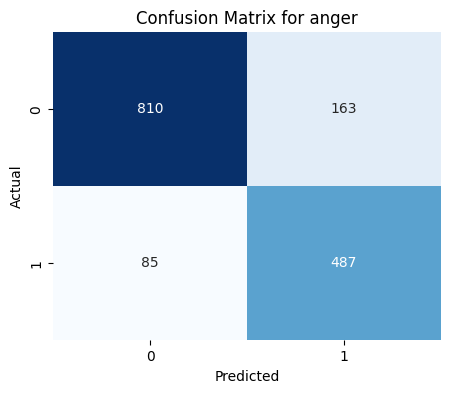

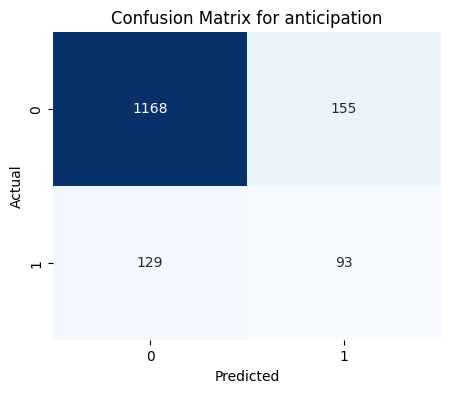

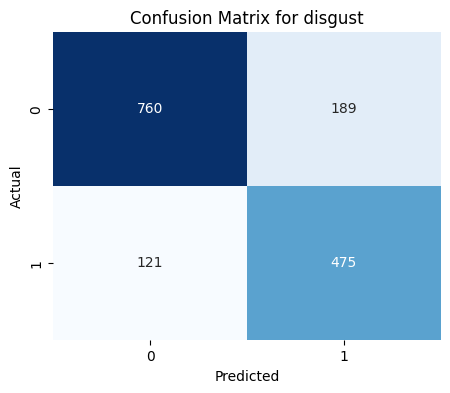

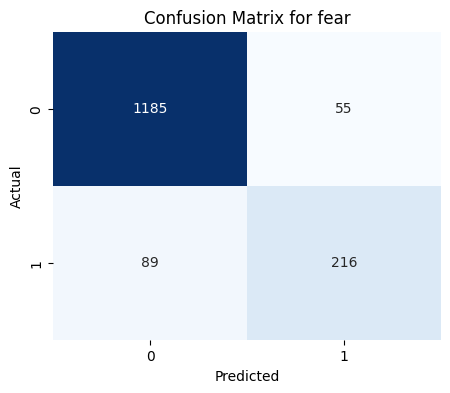

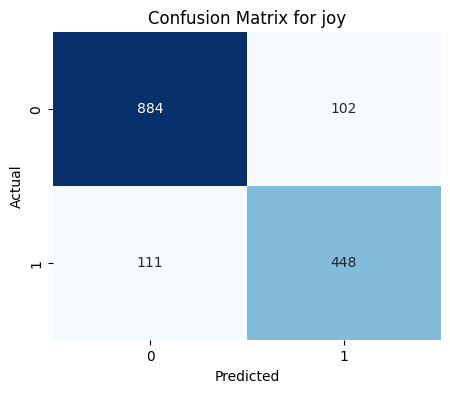

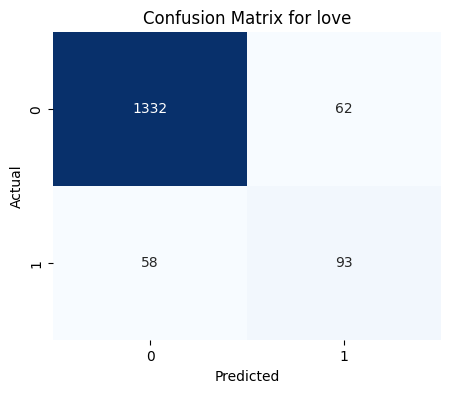

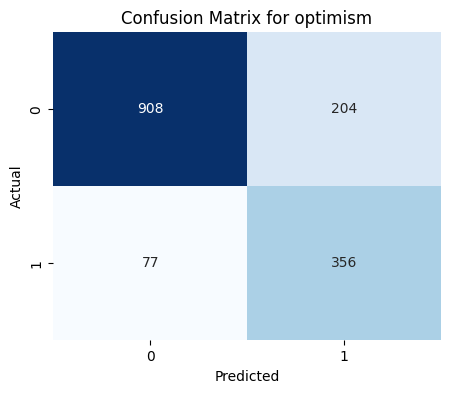

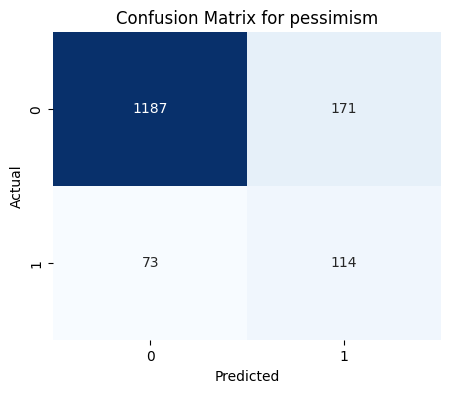

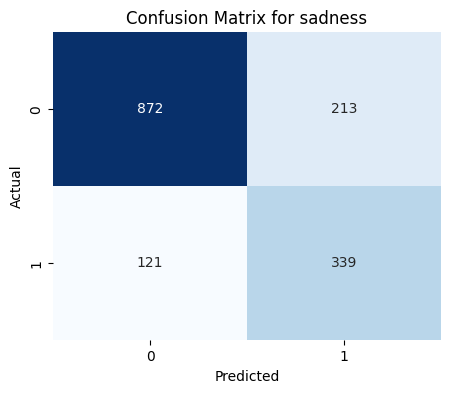

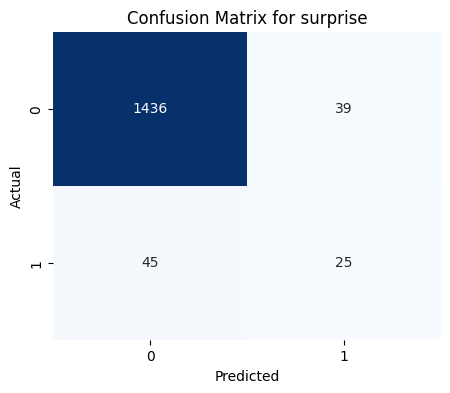

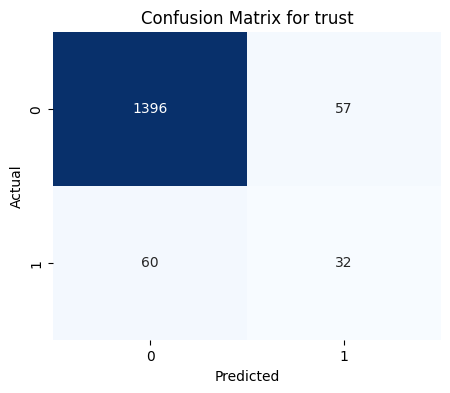

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = ["anger", "anticipation", "disgust", "fear", "joy",
               "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# Extract label values into a 2D NumPy array
true_labels = valid_dataset.select_columns(label_names)  # Select the columns in label_names
true_labels = np.array([[row[label] for label in label_names] for row in true_labels])  # Correctly extract label values

# Get predictions from the trainer
predictions = trainer.predict(tokenized_dataset["valid"])
logits = np.array(predictions.predictions)  # Access the predictions from the prediction output

## Apply sigmoid to get probabilities for multilabel classification
probs = 1 / (1 + np.exp(-logits))
# Convert probabilities to binary predictions
predictions = (probs > optimal_thresholds).astype(int)

# Plot confusion matrix for each label
for i, label in enumerate(label_names):
    # Get confusion matrix for the specific label
    cm = confusion_matrix(true_labels[:, i], predictions[:, i])  # Using numpy arrays for true_labels and predictions
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix for {label}")
    plt.show()

**The above outputs show the confusion matrices for each label, which can be used to target specific label performances**

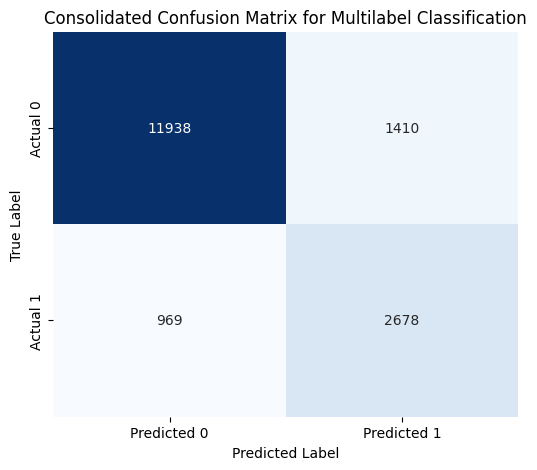

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

label_names = ["anger", "anticipation", "disgust", "fear", "joy",
               "love", "optimism", "pessimism", "sadness", "surprise", "trust"]

# Extract the true labels and predictions
true_labels = valid_dataset.select_columns(label_names)
true_labels = np.array([[row[label] for label in label_names] for row in true_labels])

# Get predictions from the trainer and convert logits to binary predictions
predictions_output = trainer.predict(tokenized_dataset["valid"])
logits = predictions_output.predictions
probs = 1 / (1 + np.exp(-logits))
predictions = (probs >optimal_thresholds).astype(int)

# Initialize a 2x2 matrix to accumulate confusion matrix counts
consolidated_cm = np.array([[0, 0], [0, 0]])

# Calculate confusion matrix for each label and sum them
for i in range(len(label_names)):
    cm = confusion_matrix(true_labels[:, i], predictions[:, i])
    consolidated_cm += cm

# Plot the consolidated confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(consolidated_cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Predicted 0", "Predicted 1"], yticklabels=["Actual 0", "Actual 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Consolidated Confusion Matrix for Multilabel Classification")
plt.show()


**<font color="blue">Step 12: Model inference</font>**

In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')
checkpoint

'/content/drive/MyDrive/Applied NLP/models/EmotionDetection-Roberta/checkpoint-700'

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
def tokenize_test_fn(batch):
    # Tokenize the text
    tokenized_inputs = tokenizer(batch["Tweet"], truncation=True, padding=True)
    return tokenized_inputs

In [ ]:
test_df = pd.DataFrame({'Tweet': testdata['Tweet']})
testdataset = Dataset.from_pandas(test_df)
tokenised_test = testdataset.map(tokenize_test_fn, batched=True)

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

In [ ]:
tokenised_test

Dataset({
    features: ['Tweet', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=128,
    do_train=False,
    do_eval=True,
    report_to=[],
    run_name=run_name
)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=tokenised_test,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-73-dd1575c7edfc>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
import pandas as pd
import numpy as np

# Run predictions
predictions_output = trainer.predict(tokenised_test)

# Get the raw logits
logits = predictions_output.predictions

# Apply sigmoid to get probabilities for multilabel classification
probs = 1 / (1 + np.exp(-logits))
# Convert probabilities to binary predictions with a threshold of 0.5
predictions = (probs >= optimal_thresholds).astype(int)

# Convert predictions to a DataFrame
predictions_df = pd.DataFrame(predictions, columns=["anger", "anticipation", "disgust", "fear", "joy",
                                                    "love", "optimism", "pessimism", "sadness", "surprise", "trust"])
predictions_df = pd.concat([testdata['ID'], predictions_df], axis=1)
predictions_df.head()

,ID,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2018-01559,1,0,1,1,0,0,0,0,0,0,0
1,2018-03739,1,0,1,0,0,0,0,1,1,0,0
2,2018-00385,1,0,1,0,0,0,0,1,1,0,0
3,2018-03001,0,0,0,0,1,0,0,0,1,0,0
4,2018-01988,0,0,0,1,0,0,0,1,1,0,0


In [ ]:
# Save predictions to CSV
predictions_df.to_csv("predictions_roberta.csv", index=False)
print("Predictions saved to predictions_roberta.csv")


Predictions saved to predictions_roberta.csv


**Conclusions and Descriptions:**
Roberta model is a variant of BERT designed specifically for sequence classification tasks. hence it is a very good choice for our experiment here. RoBERTa (A Robustly Optimized BERT Pretraining Approach) is a modification of BERT that aims to improve performance by optimizing the pretraining process.

Simlar to BERT, RoBERTa is based on the Transformer architecture with self-attention mechanisms. It includes an `encoder` with 12 layers and a classifierhead for the classification output.

RoBERTa uses word_embeddings,position_embeddings and token_type_embeddings.
RoBERTa omits the next sentence prediction objective, so it has no token type embeddings for differentiating sentence pairs, simplifying its pretraining tasks.

It uses dynamic masking instead of static masking. In BERT, the same tokens are masked in every epoch, but in RoBERTa, different tokens are masked in each training step, leading to more varied training data and richer pretraining.

RoBERTa is pretrained on much larger datasets than BERT and for longer period and can handle longer sequences, making it better suited for NLP tasks.

Overall, RoBERTa enhances BERT to handle more complex language patterns, thereby providing stronger performance without altering the core architecture of BERT.